# CNN Groceries Prediction
Computer Vision Project by Maksymilian Ormianin, Lorenz Duelli, Anton Schmidt and Jakob Jandl

## Exploration
### The Dataset
We are using the [Freiburg Groceries Dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/).
This dataset includes 5000 images of groceries, categorized into 25 different classes.

The images show the groceries as they appear on the shelf in the supermarket.

Here are some examples:

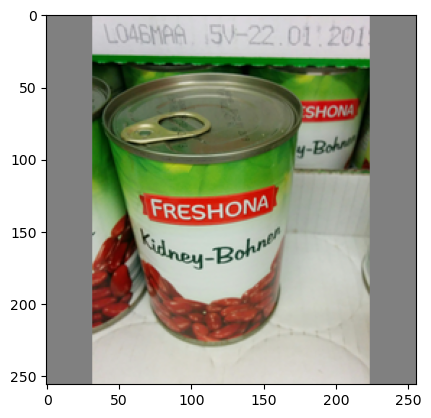

In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread("data_dir/BEANS/BEANS0000.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

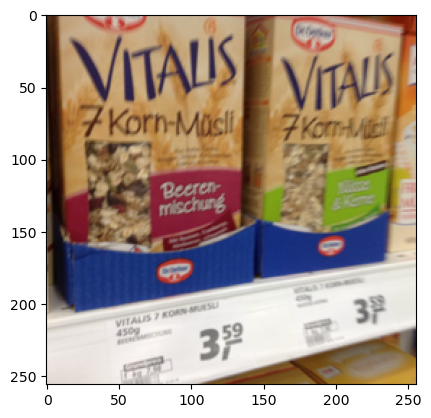

In [37]:
img2 = cv2.imread("data_dir/CEREAL/CEREAL0000.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

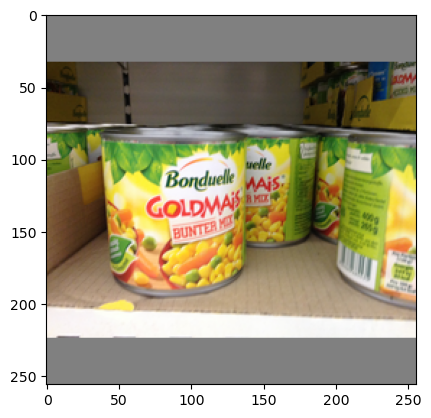

In [38]:
img3 = cv2.imread("data_dir/CORN/CORN0000.png")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img3)

### Dataset balancing
We can count the number of images for the different classes to see how balanced our dataset is:

In [40]:
# count number of images for each class
import os
from collections import Counter

# we use the data_dir to get the path to the images
data_dir = "data_dir/"

# we use a list comprehension to get the names of all the classes
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# we use a list comprehension to get the number of images for each class
num_images = [len(os.listdir(os.path.join(data_dir, d))) for d in classes]

# we use a dictionary comprehension to combine the classes and the number of images for each class
num_images_dict = {classes[i]: num_images[i] for i in range(len(classes))}
print(num_images_dict)

{'BEANS': 109, 'CAKE': 129, 'CANDY': 298, 'CEREAL': 223, 'CHIPS': 145, 'CHOCOLATE': 246, 'COFFEE': 239, 'CORN': 78, 'FISH': 88, 'FLOUR': 88, 'HONEY': 150, 'JAM': 193, 'JUICE': 242, 'MILK': 130, 'NUTS': 135, 'OIL': 115, 'PASTA': 138, 'RICE': 120, 'SODA': 142, 'SPICES': 166, 'SUGAR': 95, 'TEA': 227, 'TOMATO_SAUCE': 137, 'VINEGAR': 126, 'WATER': 210}


As we can see, the images are not perfectly balanced, the number of images per class ranges from 78 to 242.

### Other notes

- The dataset already provides a split of training and test data (the data comes in two folders labeled `data_dir` and `test_data_dir`.
- The images have a size of 256x256, however, some images have grey bars on the sides to fit into the square aspect ratio
- Since the number of classes is 25, pure guessing would lead to an accuracy of 1 in 25, or 4%
- We do not expect to get exceptionally high accuracy from our model, due to the number and the similarity of the classes

### How does the project relate to real applications?

Image classification models can be used in many different applications.

#### Some potential use-cases:

- A model that can recognize different types of groceries could be used to detect groceries in a fridge.
From that, we could derive a shopping list, or a recipe suggestion.
- Inventory management in a supermarket, to detect which products are running low.

### Loading and preprocessing the data

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "data_dir/"  # Destination directory for training data
test_data_dir = "test_data_dir/"  # Destination directory for testing data


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((100,100)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((100,100)),transforms.ToTensor()
]))

### Use DataLoader to load data in batches

In [7]:
from torch.utils.data import DataLoader

# we use a batch size of 100
# we use pin_memory to make it run more efficiently with CUDA
# we use num_workers to speed up the data loading by using multithreading
train_loader = DataLoader(dataset, batch_size=100, pin_memory=True, shuffle=True, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

### Define Model architecture

In [8]:
import torch
import torch.nn as nn

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        
        # we start with an image size of 100x100

        # First Convolutional Layer
        # keeps the size of the image (because of stride=1 and padding)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU() # activation function
        # reduces the size of the image by half (because of stride=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # image size is now 50x50

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # again reduces the size of the image by half
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # image size is now 25x25

        # the input size of the fully connected layer is 32 * 25 * 25
        # because we have 32 feature maps of size 25x25
        self.fc_input_size = 32 * 25 * 25

        # Fully Connected Layers
        # 128 is the size of the output of the fully connected layer
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.relu3 = nn.ReLU() # activation function
        # we reduce the size of the output to the number of classes we have
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Forward pass through the second convolutional layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Reshape the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        # Forward pass through the fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Create an instance of the BasicCNN model
num_classes = 25 # we have 25 different types of groceries
model = BasicCNN(num_classes)

# Print the model architecture
print(model)

BasicCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=25, bias=True)
)


### Define Loss function, Optimizer and Hyperparameters

In [9]:
import torch.optim as optim
# Define the loss function and optimizer

# this is a good loss function for classification tasks
criterion = nn.CrossEntropyLoss() 

# this is apparently a good optimizer for CNNs for image classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
epochs = 20  # You can adjust the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BasicCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=25, bias=True)
)

In [10]:
import time

t0 = time.time()

for epoch in range(epochs):
    model.train() # set the model to training mode
    running_loss = 0.0 # keep track of the loss
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # move the data to the device specified above
        optimizer.zero_grad() # initialize the gradients to zero
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # compute the loss
        loss.backward() # backward pass
        optimizer.step() # update the weights
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

t1 = time.time()
print("Finished Training in {} seconds".format(t1-t0))

Epoch 1/20, Loss: 3.0762397944927216
Epoch 2/20, Loss: 2.6593389391899107
Epoch 3/20, Loss: 2.36569402217865
Epoch 4/20, Loss: 2.1485570281744004
Epoch 5/20, Loss: 1.9125675976276397
Epoch 6/20, Loss: 1.6458195626735688
Epoch 7/20, Loss: 1.3955696851015091
Epoch 8/20, Loss: 1.1022382512688638
Epoch 9/20, Loss: 0.8581950277090072
Epoch 10/20, Loss: 0.6213670060038566
Epoch 11/20, Loss: 0.4472904123365879
Epoch 12/20, Loss: 0.28201582543551923
Epoch 13/20, Loss: 0.17476695589721203
Epoch 14/20, Loss: 0.11605272125452756
Epoch 15/20, Loss: 0.06322956802323461
Epoch 16/20, Loss: 0.038540557073429224
Epoch 17/20, Loss: 0.026245788391679525
Epoch 18/20, Loss: 0.018546567298471928
Epoch 19/20, Loss: 0.014661499066278338
Epoch 20/20, Loss: 0.011440795159433036
Finished Training in 517.6062166690826 seconds


### Model evaluation

In [11]:
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 32.55%


We get an accuracy of ~33% on the test dataset, which is not great. Lets try it with the full sized images and a larger model.

# Second approach with different preprocessing and larger images

### Calculate the mean and standard deviation of the entire dataset
We will need this to normalize the images later.

In [42]:
# we reload the data because we want to use the original image size this time
dataset_2 = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.ToTensor()
]))
test_dataset_2 = ImageFolder(test_data_dir,transforms.Compose([
    transforms.ToTensor()
]))

# we combine the datasets for the calculation of the mean and standard deviation
combined_dataset = torch.utils.data.ConcatDataset([dataset_2, test_dataset_2])

# we use the dataloader to load the data in batches
loader = DataLoader(combined_dataset, batch_size=100, num_workers=5, shuffle=True)

# we initialize the variables to zero
mean, std = 0, 0

# loop over the batches
for images, _ in loader:
    # accumulate the sum of elements
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
# calculate the mean and standard deviation
mean /= len(loader.dataset)
std /= len(loader.dataset)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.5217, 0.4581, 0.3911])
Standard Deviation: tensor([0.2380, 0.2320, 0.2286])


We now have the mean and standard deviation of the entire dataset. We can use this information to normalize the images which might help with the training.

### Define the new transformations including the calculated mean and standard deviation

In [49]:
# we define the new transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # we randomly flip the images horizontally to increase model robustness
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# we reload the data with the new transformations
dataset_3 = ImageFolder(data_dir,transform = train_transform)
test_dataset_3 = ImageFolder(test_data_dir,transform = test_transform)

### Use DataLoader to load data in batches

In [50]:
train_loader_3 = DataLoader(dataset_3, batch_size=100, pin_memory=True, shuffle=True, num_workers=5)
test_loader_3 = DataLoader(test_dataset_3, batch_size=100, shuffle=True)

### New model architecture for larger images with additional convolutional layer

In [57]:
class LargerModel(nn.Module):
    def __init__(self, num_classes):
        super(LargerModel, self).__init__()
        
        # we start with an image size of 256x256   
        # we have doubled the number of output channels for the convolutional layers

        # First Convolutional Layer
        # keeps the size of the image (because of stride=1 and padding)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU() # activation function
        # reduces the size of the image by half (because of stride=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # image size is now 128x128

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # again reduces the size of the image by half
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # image size is now 64x64
        
        # We have added additional convolutional layer
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        # again reduces the size of the image by half
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # image size is now 32x32

        # the input size of the fully connected layer is 32 * 32 * 32
        # because we have 32 feature maps of size 32x32
        self.fc_input_size = 128 * 32 * 32

        # Fully Connected Layers
        # 256 is the size of the output of the fully connected layer
        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.relu4 = nn.ReLU() # activation function
        # we reduce the size of the output to the number of classes we have (25)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # Reshape the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        # Forward pass through the fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# Create an instance of the new larger model
num_classes = 25
model = LargerModel(num_classes)

# Print the model architecture
print(model)

LargerModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=25, bias=True)
)


### Re-define optimizer with new parameters and move to gpu

In [58]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # loss function stays the same

# we need to re-define the optimizer with the new parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

model.to(device)

LargerModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=25, bias=True)
)

In [59]:
import time

t0 = time.time()

for epoch in range(epochs):
    model.train() # set the model to training mode
    running_loss = 0.0 # keep track of the loss
    for inputs, labels in train_loader_3:
        inputs, labels = inputs.to(device), labels.to(device) # move the data to the device specified above
        optimizer.zero_grad() # initialize the gradients to zero
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # compute the loss
        loss.backward() # backward pass
        optimizer.step() # update the weights
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

t1 = time.time()
print("Finished Training in {} seconds".format(t1-t0))

Epoch 1/20, Loss: 3.4166216790676116
Epoch 2/20, Loss: 2.7137154042720795
Epoch 3/20, Loss: 2.3310376405715942
Epoch 4/20, Loss: 2.0352473199367522
Epoch 5/20, Loss: 1.6560847193002701
Epoch 6/20, Loss: 1.1928448781371117
Epoch 7/20, Loss: 0.788725745677948
Epoch 8/20, Loss: 0.4711711347103119
Epoch 9/20, Loss: 0.2987987376749516
Epoch 10/20, Loss: 0.19082446824759244
Epoch 11/20, Loss: 0.12420302834361792
Epoch 12/20, Loss: 0.0923642311245203
Epoch 13/20, Loss: 0.04907131309155375
Epoch 14/20, Loss: 0.032592013315297666
Epoch 15/20, Loss: 0.0208803141140379
Epoch 16/20, Loss: 0.01239395782176871
Epoch 17/20, Loss: 0.01620300962240435
Epoch 18/20, Loss: 0.008041286119259894
Epoch 19/20, Loss: 0.01567104352870956
Epoch 20/20, Loss: 0.004517025526729413
Finished Training in 3347.3071258068085 seconds


### Loss graph

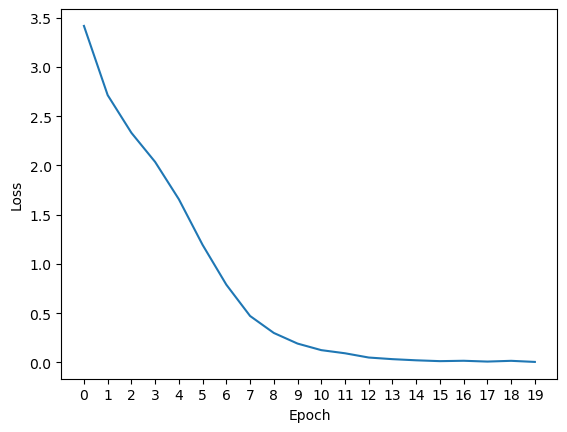

In [108]:
# we copy the values manually so that we dont have to run the training again (which takes a long time)
loss_list = [3.4166216790676116, 2.7137154042720795, 2.3310376405715942, 2.0352473199367522, 1.6560847193002701, 1.1928448781371117, 0.788725745677948, 0.4711711347103119, 0.2987987376749516, 0.19082446824759244, 0.12420302834361792, 0.0923642311245203, 0.04907131309155375, 0.032592013315297666, 0.0208803141140379, 0.01239395782176871, 0.01620300962240435, 0.008041286119259894, 0.01567104352870956, 0.004517025526729413]

# we plot the loss graph
plt.plot(loss_list)
plt.xticks(range(epochs))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Model evaluation

In [60]:
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_3:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the new model with larger images: {accuracy:.2f}%")

Accuracy of the new model with larger images: 36.02%


### Evaluation
It seems that the larger model with the higher resolution images only performs marginally better than the smaller model, which is a bit disappointing.
It also appears like the model is over-fitted, due to the very low loss at the end of the training.
To test this we could try to evaluate the accuracy on the training data instead of on the test data.

In [61]:
# Evaluate the model on the training dataset to see if it is over-fitted
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader_3:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total
print(f"Accuracy of the model on the training data: {accuracy:.2f}%")

Accuracy of the model on the training data: 100.00%


The accuracy of the model on the training data is 100%... so the model is *very* over-fitted.
We tried to fix this, however, we did not have much success.
So it seems like we are stuck at around 36% accuracy.
This is not terrible for a model with 25 classes, but it is also not great.
Lets still try to visualize some predictions:

### Visualization of the model

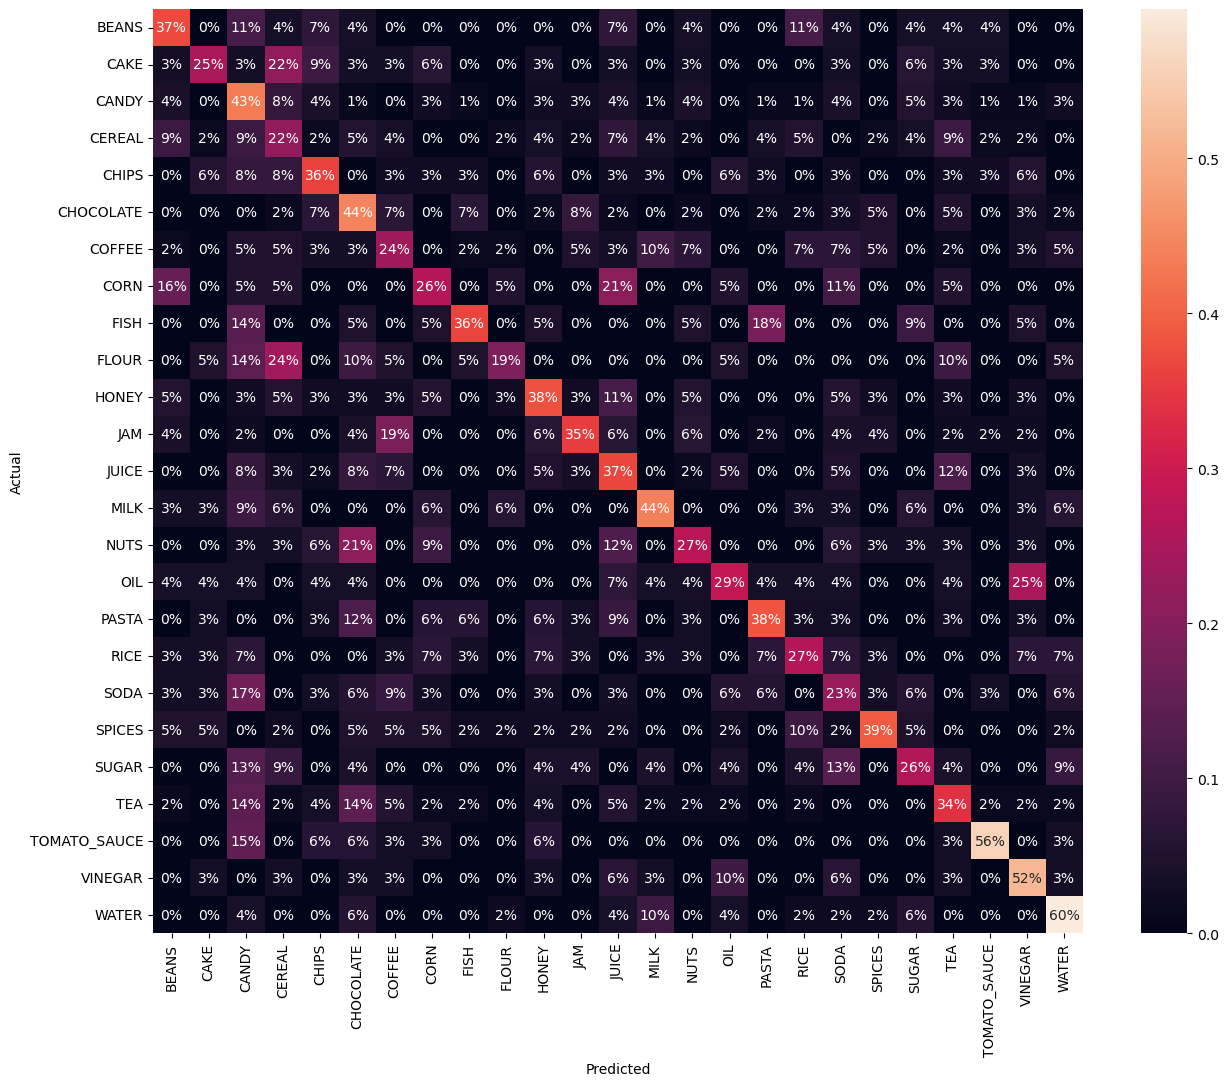

In [105]:
# lets try to visualize the model with a confusion matrix
from sklearn.metrics import confusion_matrix

# we get the predictions for the test dataset
model.eval()
predictions = []
ground_truth = []
with torch.no_grad():
    for inputs, labels in test_loader_3:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())
        
# we get the class names
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_names = np.array(classes)

# we create the confusion matrix with percent values
cm = confusion_matrix(ground_truth, predictions, normalize='true')

# we plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Best Prediction: Water
- We can see that the best prediction is for water, where 60% of the actual water images are predicted correctly.
- Water is most often confused with milk, with the model predicting 10% of the water images as milk.
#### Worst Prediction: Flour
- Flower is only correctly predicted 19% of the time.
- It is more often (24% of the time) predicted as cerial than flour.
#### Most common confusion: Oil predicted Vinegar
- Oil is predicted as vinegar 25% of the time.
- Interestingly, vinegar is only predicted as oil 10% of the time.
#### Other common confusions
- Nuts predicted as chocolate (21%)
- Cake predicted as cereal (22%)
    - This makes sense since the cake depicted in the images is usually cake mix instead of a finished cake, so the cardboard box looks similar to a cereal box
- Corn predicted as juice (21%)

### Visualization of some predictions

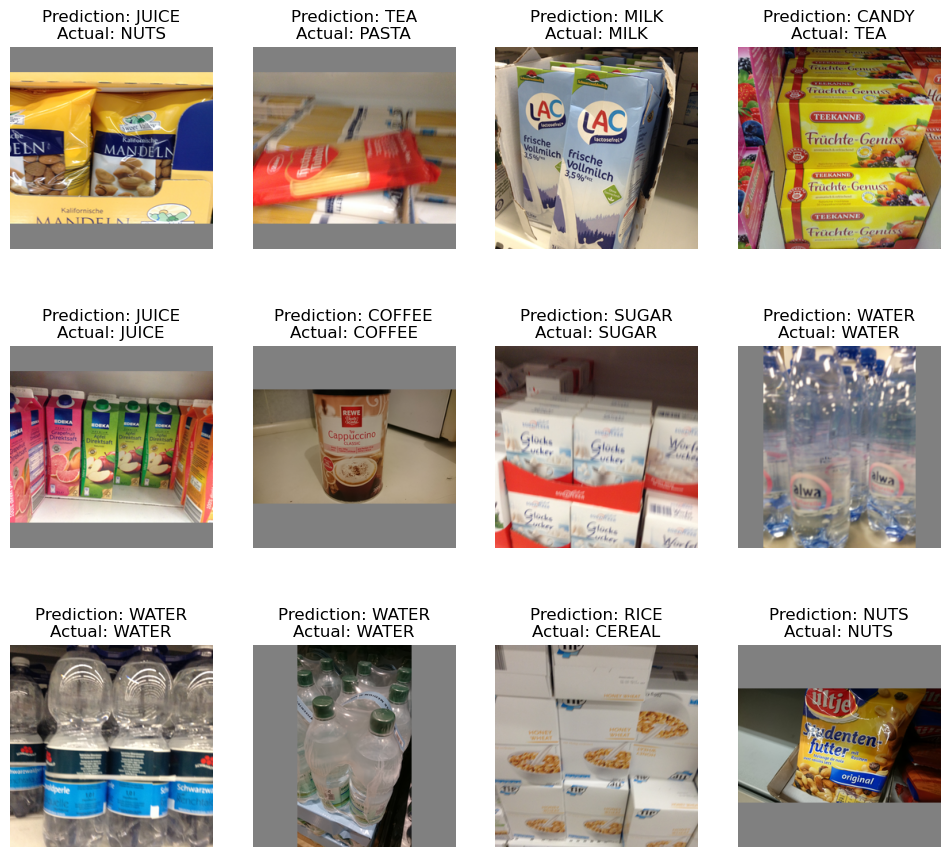

In [99]:
import numpy as np

# we get 20 images from the test dataset
loader = DataLoader(test_dataset_3, batch_size=12, num_workers=5, shuffle=True)
images, labels = next(iter(loader))

# we get the class names and the ground truth for our 20 images
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_names = np.array(classes)
ground_truth = class_names[labels]

# we move the images to the device
images = images.to(device)

# we get the predictions
outputs = model(images)

# we get the predicted class
_, predicted = torch.max(outputs.data, 1)

# we get the predicted class
predicted_class = class_names[predicted.cpu()]

# we get the images from the batch
images = images.cpu()

# we denormalize the images so that they look normal
denormalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std=[1/std[0], 1/std[1], 1/std[2]]),
    transforms.Normalize(mean = [ -mean[0], -mean[1], -mean[2] ], std = [ 1., 1., 1. ]),
])

images = denormalize(images)

# we convert the images to numpy for visualization
images = images.numpy()

# we transpose the images to the correct shape
images = np.transpose(images, (0, 2, 3, 1))

# we plot the images
fig, axes = plt.subplots(figsize=(12,11), ncols=4, nrows=3)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(f"Prediction: {predicted_class[i]}\nActual: {ground_truth[i]}")
    ax.axis('off')

plt.show()

### Which problems did we encounter and how did we solve them?

- The images are provided in folders that are named after their respective class
    - We first wanted to use scikit-learn for our model, but loading the files provided in this structure turned out to be quite tricky
    - However, we realized that PyTorch has a built-in function to load images from folders in this structure called `ImageFolder`
        - This function also allows us to easily apply transformations to the images, which we can use to resize the images to a smaller size
- We had trouble getting our model to train on the GPU
    - It was tricky to get CUDA running on an nvidia GPU since pytorch requires a specific version
    - We eventually got it running and we can now run the model on the gpu by calling model.to(device)
- Training time was way too long
    - We solved this by using a DataLoader to load the data in batches
        -  Here it was important to set the `pin_memory` parameter to `True` to make it run more efficiently with CUDA
- The accuracy was terrible in the beginning (just around 4%)
    - We modified our model architecture
    - We tried different optimizers and learning rates
- The model is very over-fitted
    - We tried different parameters and model sizes to reduce over-fitting, but did not have much success
    - In the end, our accuracy is still only around 36%, but at least it is significantly better than random guessing

# The End